# Modelo de clasificación de autos y motos.

En esta notebook se realiza un clasificador de autos y motos utilizando técnicas de machine learning. Las imágenes utilizadas para entrenar los diferentes modelo fueron obtenidos de la pagina kaggle, https://www.kaggle.com/prasunroy/natural-images , y de la pagina pascal, http://host.robots.ox.ac.uk/pascal/VOC/voc2005/index.html . Para correr la notebook se utilizo google colab.

Se entranaron diferentes modelos de machine learning. Entre ellos:
* Logistic Regression
* Support Vector Classification
* Bagging Classifier
* RandomForest Classifier
* AdaBoost Classifier

Mediante un random search y cross validation busco el algoritmo que mayor accuracy logra. El algoritmo que mejor performance tuvo fue Support Vector Classification. Luego se procede a su optimizacion mediante grid search y cross validation. Una vez optimizado el modelo se procede a ver su performance en los datos de testeo, finalmente se crear una clase para su serialización y puesta en producción.

In [4]:
# Importo las librerias que voy a utilizar
import os, cv2
import numpy as np
import pandas as pd
import pickle
import scipy
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt 
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Primero hago una clase para poder convertir las imagenes al formato que necesito para entrenar el modelo .

In [18]:
class Transformar_imagen():
    def __init__(self):
        # Voy a transformar las imagenes a 64 pixeles y a formato rgb
        self.rows = 64
        self.cols = 64
        self.channels = 3
    def ruta(self,ubicaciones):
      # para obtener las ubicacion de todas las imagenes
        total_imagenes = []
        for ubicacion in ubicaciones:
            total_imagenes += [ubicacion+i for i in os.listdir(ubicacion)]
        return total_imagenes
    def leer_imagen(self,direccion):
      # leo las imagenes con la libreria cv2
        img = cv2.imread(direccion,cv2.IMREAD_COLOR)
        return cv2.resize(img,(self.rows,self.cols),interpolation=cv2.INTER_CUBIC)
    def transform(self,ubicaciones):
      # transformo las imagenes y creo un numpy array con las features. Que en este caso seria 64 pixeles por lado y 3 dimensiones.
      # Por lo que quedarias 64 * 64 * 3 = 12288 columnas 
      # Luego creo el target igual a 1 si es un auto y igual a 0 si es una moto
        imagenes = self.ruta(ubicaciones)
        m = len(imagenes)
        n_x = self.rows * self.cols * self.channels
        X = np.ndarray((n_x,m), dtype=np.uint8)
        y = np.zeros((1,m))
        print("X.shape es {}".format(X.shape))
        for i, archivo_imagen in enumerate(imagenes):
            imagen = self.leer_imagen(archivo_imagen)
            X[:,i] = np.squeeze(imagen.reshape((n_x,1)))
            if 'car' in archivo_imagen.lower():
                y[0,i] = 1
            elif 'bike' in  archivo_imagen.lower():
                y[0,i] = 0
            else:
                y[0:i] = archivo_imagen.split('/')[-1].split('.')[0]
            if i % 500 == 0:
                print("proceso {} de {}".format(i,m))
        return X.T,y.T.ravel()

La clase despues de ser instanciada tiene un metodo llamado transform. Este recibe como parametro la ubicacion de las imagenes y luego las transforma al formato definido por la clase.
Devuelve un numpy array de las features y un vector columna con los target.

In [19]:
# Leo los datos y los transformo.
# Las imagenes se encuentran en mi cuenta de google drive
transformador = Transformar_imagen()
ubicacion = ["/content/drive/My Drive/datasets /cars/","/content/drive/My Drive/datasets /motorbikes/"]
X, y = transformador.transform(ubicacion)

X.shape es (12288, 3578)
proceso 0 de 3578
proceso 500 de 3578
proceso 1000 de 3578
proceso 1500 de 3578
proceso 2000 de 3578
proceso 2500 de 3578
proceso 3000 de 3578
proceso 3500 de 3578


Una vez obtenido las features y el target. Se normaliza las columnas, los pixeles, ya que van sus valores desde el 0 hasta 255.

Luego se dividen los datos en entrenamiento y test, dejando un 20% de los datos para testeo.

In [20]:
X_normalizado = X/255
X_train, X_test, y_train, y_test = train_test_split(X_normalizado,y,stratify=y,test_size=0.2,random_state=42)

In [21]:
print("Train shape: {}".format(X.shape))
print("Test shape: {}".format(y.shape))

Train shape: (3578, 12288)
Test shape: (3578,)


In [22]:
# Se ve que las clases estan balanceadas.
# Hay 1926 imagenes de autos y 1652 de motos
pd.Series(y).value_counts()

1.0    1926
0.0    1652
dtype: int64

Mediante un pipeline para poder elegir el mejor modelo, se utilizan 2 pasos.

Primero se reduce la dimensionalidad de los datos, ya que se cuenta con 12288 columnas(una por cada pixel) y solo 3578 observaciones, para poder evitar el overfitting. Para ello se reduce la dimensión de los datos con PCA para quedarnos con los primeros componentes principales que explican el 80% de la varianza de los datos.  

Luego mediante un random search se busca entre los diferentes modelos y con diferentes hiperparametros.

In [ ]:
pasos = [
    ("Reduccion",PCA(0.8)),
    ("Modelo",LogisticRegression())
]
pipeline = Pipeline(pasos)

In [23]:
# Se ven diferentes modelos con diferentes hiperparametros
parametros= [{
    "Modelo":[LogisticRegression()],
    "Modelo__C":scipy.stats.expon(),
    "Modelo__penalty":["l1", "l2"],
    "Modelo__solver":["lbfgs", "liblinear", "sag"]
},
{
    "Modelo":[SVC()],
    "Modelo__C":scipy.stats.expon(),
    "Modelo__kernel":["linear", "poly", "rbf"]
},
{
    "Modelo":[RandomForestClassifier()],
    "Modelo__n_estimators":scipy.stats.randint(low=100,high=1000),
    "Modelo__max_depth":scipy.stats.randint(low=100,high=1000),
    "Modelo__min_samples_split":scipy.stats.randint(low=1,high=100)
},
{
    "Modelo":[AdaBoostClassifier(base_estimator=DecisionTreeClassifier())],
    "Modelo__n_estimators":scipy.stats.randint(low=100,high=1000)
},
{
    "Modelo":[BaggingClassifier(base_estimator=DecisionTreeClassifier())],
    "Modelo__n_estimators":scipy.stats.randint(low=100,high=1000)
}
]
cv = KFold(n_splits=3,shuffle=True,random_state=42)

In [ ]:
# Se hace el random search cv
random = RandomizedSearchCV(pipeline,parametros,cv=cv,n_jobs=-1,n_iter=50)

In [ ]:
# Se fitea el modelo
random.fit(X_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('Reduccion',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=0.8,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('Modelo',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept

Una vez fiteado el modelo, en la siguiente celda se comprueba que el mejor modelo es el de Support Vector Classification. El modelo logra un accuracy del 0.88. Por lo que en un 88% de las veces el modelo predice bien la imagen.

In [ ]:
random.best_params_,random.best_score_

({'Modelo': SVC(C=1.2024103856730022, break_ties=False, cache_size=200, class_weight=None,
      coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
      kernel='rbf', max_iter=-1, probability=False, random_state=None,
      shrinking=True, tol=0.001, verbose=False),
  'Modelo__C': 1.2024103856730022,
  'Modelo__kernel': 'rbf'},
 0.8822501747030049)

Se optimiza el parametro C del modelo con un grid search para tratar de mejorar aun mas el accuracy. 

In [24]:
pipeline_svc = Pipeline([("Reduccion",PCA(0.8)),
                         ("Modelo",SVC())
                         ])
parametros_svc = {
    "Modelo__C":np.linspace(1.5,4,20)
}
cv = KFold(n_splits=3,shuffle=True,random_state=42)

In [25]:
grid_svc = GridSearchCV(pipeline_svc,parametros_svc,cv=cv,n_jobs=-1,verbose=1)

In [26]:
grid_svc.fit(X_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 17.7min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Reduccion',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.8, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('Modelo',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr...
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'Modelo__C': array([1.5       , 1.63157895, 1.76315789, 1.89473684, 2.0

In [27]:
# El accuracy sube un poco
grid_svc.best_params_,grid_svc.best_score_

({'Modelo__C': 2.9473684210526314}, 0.8888888888888888)

Se utiliza el modelo optimizado para ver como es su resultado en los datos de testeo.

In [28]:
y_pred = grid_svc.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88       331
         1.0       0.88      0.93      0.91       385

    accuracy                           0.90       716
   macro avg       0.90      0.89      0.89       716
weighted avg       0.90      0.90      0.89       716



Se ve que accuracy del modelo es de 0.90. Por lo que acerto es un 90% de las imagenes de testeo.

La precisión para los autos es de 0.88, por que de las veces que el modelo predijo que era un auto, en el 88% de las veces acertamos. El recall o sensibilidad del modelo para los autos es de 0.93. Esto quiere decir que el modelo predijo que eran auto el 93% de todas las imagenes de testeo que eran autos.

La precisión para el las motos fue del 0.91, cuando el modelo predijo que era una moto, acerto en el 0.91% de las veces. Y el recall o sensibilidad es igual a 0.85 para la clase moto, por lo que de todas las imagenes de testo que eran motos en el 85% de las veces el modelo dijo que eran motos.


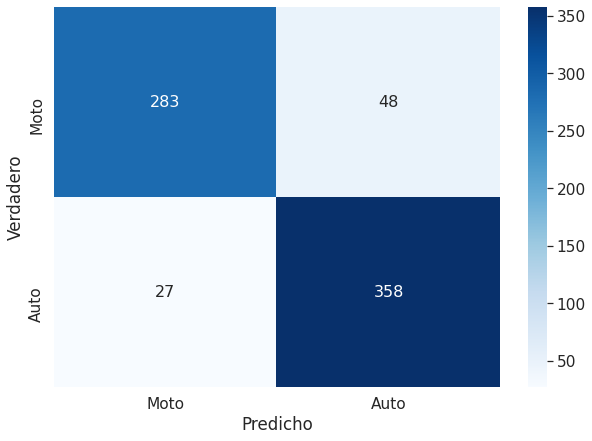

In [29]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=["Moto","Auto"], index =["Moto","Auto"])
df_cm.index.name = 'Verdadero'
df_cm.columns.name = 'Predicho'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt="d",annot_kws={"size": 16})# font size

En la matriz de confusión se ve que los verdaderos negativos son igual a 283 y los verdaderos positivos son iguales a 358. Los falsos positivos son igual a 48 y los falsos negativos igual a 27.

Verifico las predicciones que realizo el modelo en testeo con sus respectivas imagenes. Para tal fin se crea un funcion que toma las imagenes, el modelo o la predicicon y las clases con sus respectivos nombres.

In [33]:
def show_image_prediction(X, idx, model, clases,tipo="modelo") :
  image = X[idx].reshape(1,-1)
  if tipo == "modelo":
    image_class = clases[model.predict(image).item()]
  elif tipo == "prediccion":
    image_class = clases[model[idx]]
  else:
    return "Seleccione el tipo correcto"
  image = image.reshape((64, 64, 3))
  plt.figure(figsize = (4,2))
  plt.imshow(image)
  plt.title("Test {} : Creo que es {}".format(idx, image_class))
  plt.show()

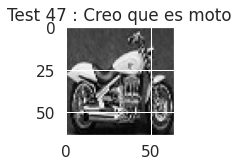

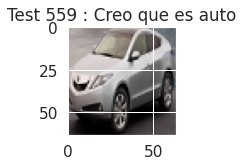

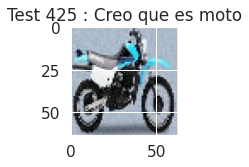

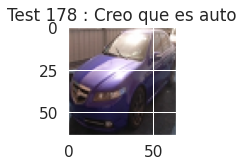

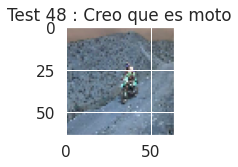

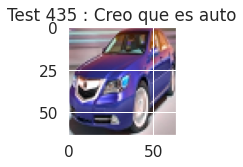

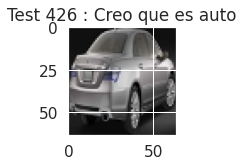

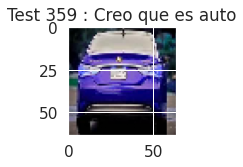

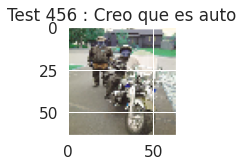

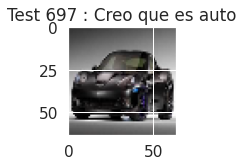

In [34]:
# elijo 10 imagenes al azar para ver su predicción
for i in np.random.randint(0, len(X_test), 10) :
  show_image_prediction(X_test, i, grid_svc,clases={0:"moto",1:"auto"})

De las imagenes de testeo tomadas al azar, se puede ver que acerto 9 de 10

## Serializamos el modelo
Utilizo la libreria pickle para guardar el modelo y poder utilizarlo para predecir imagenes que le pase despues.
Además se crea una clase que hace las transformaciones necesarias y utilizando el modelo ya entrenado, devuelve una predicción de las imagenes pasadas a la clase

In [35]:
# with grid_svc.best_estimator_
with open('best_estimator.pkl', 'wb') as grid_estimator:
    pickle.dump(grid_svc.best_estimator_, grid_estimator)

In [36]:
# observamos si los archivos se crearon en la carpeta en donde estamos ejecutando la notebook
[x for x in os.listdir() if 'pkl' in x]

['best_estimator.pkl']

In [38]:
# Descargo el archivo a mi computadora
from google.colab import files
files.download("best_estimator.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Se crea una clase para hacer todas las transformaciones necesarias y que el modelo pueda hacer la predicción, además se carga el modelo con pickle para no tener que entrenarlo y poder tenerlo listo para producción.

La el método predict de la clase recibe la ubicación de las imágenes a predecir y devuelve la predicción en formato binario.

In [39]:
class Clasificador():
    def __init__(self):
        self.rows = 64
        self.cols = 64
        self.channels = 3
    def ruta(self,ubicaciones):
        total_imagenes = []
        for ubicacion in ubicaciones:
            total_imagenes += [ubicacion+i for i in os.listdir(ubicacion)]
        return total_imagenes
    def leer_imagen(self,direccion):
        img = cv2.imread(direccion,cv2.IMREAD_COLOR)
        return cv2.resize(img,(self.rows,self.cols),interpolation=cv2.INTER_CUBIC)
    def crear_x(self,ubicaciones):
        imagenes = self.ruta(ubicaciones)
        m = len(imagenes)
        n_x = self.rows * self.cols * self.channels
        X = np.ndarray((n_x,m), dtype=np.uint8)
        for i, archivo_imagen in enumerate(imagenes):
            imagen = self.leer_imagen(archivo_imagen)
            X[:,i] = np.squeeze(imagen.reshape((n_x,1)))
        return X.T / 255
    def predict(self,direccion):
        X = self.crear_x(direccion)
        with open('./best_estimator.pkl','rb') as modelo_grid:
            modelo_listo = pickle.load(modelo_grid)
        y_pred = modelo_listo.predict(X)
        return y_pred

Instancio el modelo, creo los datos a testear, utilice imágenes sacadas de google y obtengo las predicciones.

In [40]:
clasi = Clasificador()
x_test = clasi.crear_x(["/content/drive/My Drive/datasets /test_2/car/"])
y_pred = clasi.predict(["/content/drive/My Drive/datasets /test_2/car/"])

Utilizo la función creada para ver cada imagen con su predicción correspondiente.

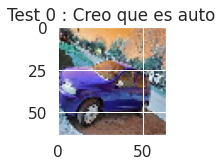

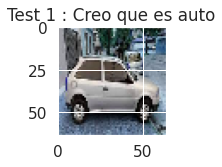

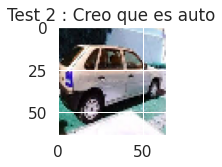

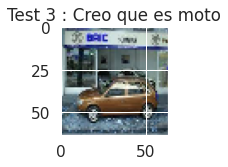

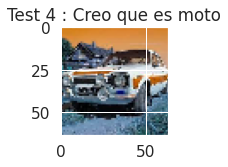

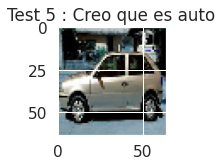

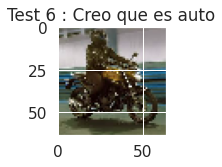

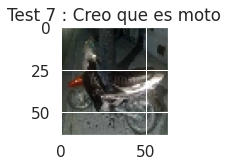

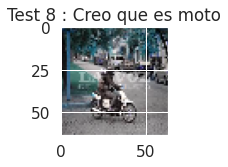

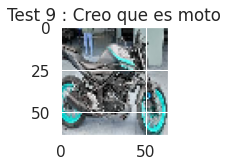

In [43]:
for i in range(0, len(x_test)) :
  show_image_prediction(x_test, i, y_pred,clases={0:"moto",1:"auto"} ,tipo="prediccion")

El modelo predijo 7 imágenes correctamente de 10. Es un modelo relativamente bueno tiniendo en cuenta que se han utilizado solo técnicas de machine learning.